# 99th Percentile- Precp


### Inserting all required libraries

In [406]:
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.axes as ax

### Gettign data through API request

In [407]:
api = 'http://api.cal-adapt.org/api'
headers = {'ContentType': 'json'}

# Your point of interest
point = 'POINT(-118.3089 34.1808)'

# Name of boundary layer in API
resource = 'locagrid'

# Request url
url = api + '/' + resource + '/'
# Request params to find intersecting polygon
params = {'intersects': point, 'srs': 4326, 'simplify': .0001, 'precision': 4}
ref = ''
location = ''

# Get geometry
response = requests.get(url, params=params, headers=headers)
if response.ok:
    data = response.json()
    print(data)
    feature = data['features'][0]
    if (feature):
        ref = '/api/%s/%s/' % (resource, feature['id'])
        #location = feature['properties']['name']
        print('ref =', ref)
        #print('location =', location)
    else:
        print('Did not find any polygons that intersect your point')
params = {'ref': ref, 'stat': 'mean'}
#print(data)

{'count': 1, 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'features': [{'geometry': {'type': 'Polygon', 'coordinates': [[[-118.3125, 34.1875], [-118.25, 34.1875], [-118.25, 34.125], [-118.3125, 34.125], [-118.3125, 34.1875]]]}, 'type': 'Feature', 'properties': {}, 'id': 47408}], 'next': None, 'type': 'FeatureCollection', 'previous': None}
ref = /api/locagrid/47408/


In [408]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}


def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        #print('Processing:', slug)
        json = response.json()
        data = json['results'][0]
        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()# Get total number of values -> number of days
            #dft = pd.DataFrame(data['image'])
            #print(dft.head(10))
            #length = len(dft)
        length = len(values_arr)
        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')
        
        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index= pd.date_range(start_date, freq='1D', periods=length),
            columns=['value']
        )

      
            
        # Add slug as a column
        df['slug'] = slug  

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

### Change the below parameters as required

In [409]:
def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['pr']
    period = ['day']
    models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5']
    scenarios = ['historical','rcp85', 'rcp45']
    zipped = itertools.product(climvar, period, models, scenarios)
    
    # Request parameters
    params = {'ref': ref, 'stat': 'mean'}

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

### Visulizing the data set

In [410]:
projectedDF = get_projections()
projectedDF.head(10)

,value,slug
1950-01-01,0.000034,pr_day_CanESM2_historical
1950-01-02,0.000004,pr_day_CanESM2_historical
1950-01-03,0.000000,pr_day_CanESM2_historical
1950-01-04,0.000000,pr_day_CanESM2_historical
1950-01-05,0.000000,pr_day_CanESM2_historical
1950-01-06,0.000000,pr_day_CanESM2_historical
1950-01-07,0.000000,pr_day_CanESM2_historical
1950-01-08,0.000000,pr_day_CanESM2_historical
1950-01-09,0.000000,pr_day_CanESM2_historical
1950-01-10,0.000002,pr_day_CanESM2_historical


In [411]:
# Keep only required parameters in slug
temp = projectedDF['slug'].str.split('_', expand=True)[2] + str("_")+projectedDF['slug'].str.split('_', expand=True)[3]
projectedDF['test'] = temp
projectedDF.index.name = 'Date'

projectedDF.drop(columns= 'slug', inplace = True)
projectedDF.head()

,value,test
Date,,
1950-01-01,0.000034,CanESM2_historical
1950-01-02,0.000004,CanESM2_historical
1950-01-03,0.000000,CanESM2_historical
1950-01-04,0.000000,CanESM2_historical
1950-01-05,0.000000,CanESM2_historical


In [412]:
projectedDF.head()

,value,test
Date,,
1950-01-01,0.000034,CanESM2_historical
1950-01-02,0.000004,CanESM2_historical
1950-01-03,0.000000,CanESM2_historical
1950-01-04,0.000000,CanESM2_historical
1950-01-05,0.000000,CanESM2_historical


### Using pivot tables to split column 'test' values to rows

In [413]:
projectedDF = projectedDF.pivot_table( values = 'value', index = 'Date', columns = 'test')

### Combining historical & rcp 4.5 AND historical & rcp 8.5

In [414]:
projectedDF['CNRM-CM5_rcp45'].fillna(projectedDF['CNRM-CM5_historical'], inplace=True)
projectedDF['CNRM-CM5_rcp85'].fillna(projectedDF['CNRM-CM5_historical'], inplace=True)
del projectedDF['CNRM-CM5_historical']

projectedDF['CanESM2_rcp45'].fillna(projectedDF['CanESM2_historical'], inplace=True)
projectedDF['CanESM2_rcp85'].fillna(projectedDF['CanESM2_historical'], inplace=True)
del projectedDF['CanESM2_historical']

projectedDF['HadGEM2-ES_rcp45'].fillna(projectedDF['HadGEM2-ES_historical'], inplace=True)
projectedDF['HadGEM2-ES_rcp85'].fillna(projectedDF['HadGEM2-ES_historical'], inplace=True)
del projectedDF['HadGEM2-ES_historical'] 

projectedDF['MIROC5_rcp45'].fillna(projectedDF['MIROC5_historical'], inplace=True)
projectedDF['MIROC5_rcp85'].fillna(projectedDF['MIROC5_historical'], inplace=True)
del projectedDF['MIROC5_historical']             
                
#df.columns = 'File heat Observations'.split()

In [415]:
# Visulazing first few rows 
projectedDF = projectedDF.apply(lambda x: x*86400) #change units to precp mm/day
projectedDF.head()

test,CNRM-CM5_rcp45,CNRM-CM5_rcp85,CanESM2_rcp45,CanESM2_rcp85,HadGEM2-ES_rcp45,HadGEM2-ES_rcp85,MIROC5_rcp45,MIROC5_rcp85
Date,,,,,,,,
1950-01-01,26.079236,26.079236,2.973972,2.973972,0.342724,0.342724,0.0,0.0
1950-01-02,45.497108,45.497108,0.366424,0.366424,0.231767,0.231767,0.0,0.0
1950-01-03,49.179868,49.179868,0.000000,0.000000,0.014053,0.014053,0.0,0.0
1950-01-04,3.661456,3.661456,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1950-01-05,0.452262,0.452262,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [416]:
# Visulazing last few rows in the dataset
projectedDF.head()

test,CNRM-CM5_rcp45,CNRM-CM5_rcp85,CanESM2_rcp45,CanESM2_rcp85,HadGEM2-ES_rcp45,HadGEM2-ES_rcp85,MIROC5_rcp45,MIROC5_rcp85
Date,,,,,,,,
1950-01-01,26.079236,26.079236,2.973972,2.973972,0.342724,0.342724,0.0,0.0
1950-01-02,45.497108,45.497108,0.366424,0.366424,0.231767,0.231767,0.0,0.0
1950-01-03,49.179868,49.179868,0.000000,0.000000,0.014053,0.014053,0.0,0.0
1950-01-04,3.661456,3.661456,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1950-01-05,0.452262,0.452262,0.000000,0.000000,0.000000,0.000000,0.0,0.0


### Global settings for all graphs in this notebook

In [417]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (10.0, 7.0)

### Calculating 99th and 95th percentile based upon 30 year window (CNRM-CM5)

In [418]:
cnrm45_quant99 = projectedDF['CNRM-CM5_rcp45'].rolling(20000).quantile(.99, interpolation='lower')
cnrm45_quant95 = projectedDF['CNRM-CM5_rcp45'].rolling(20000).quantile(.95, interpolation='lower')
cnrm85_quant99 = projectedDF['CNRM-CM5_rcp85'].rolling(20000).quantile(.99, interpolation='lower')
cnrm85_quant95 = projectedDF['CNRM-CM5_rcp85'].rolling(20000).quantile(.95, interpolation='lower')


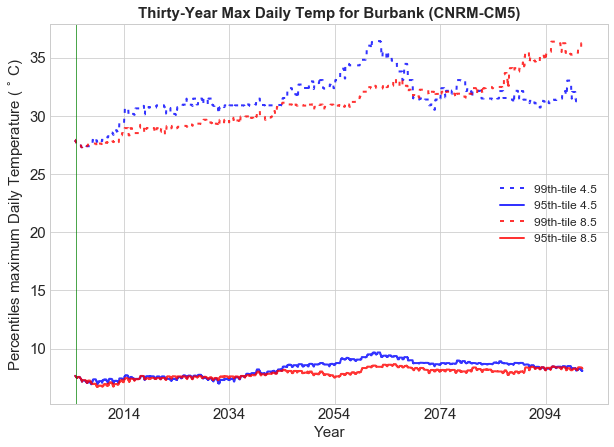

In [419]:
plt.plot(projectedDF.index, cnrm45_quant99, color = 'b', ls = 'dashed', dashes=(2, 3), alpha = 0.8, label = '99th-tile 4.5')
plt.plot(projectedDF.index, cnrm45_quant95, color = 'b', ls = 'solid', alpha = 0.8, label = '95th-tile 4.5')
plt.plot(projectedDF.index, cnrm85_quant99, color = 'r', ls = 'dashed', dashes=(2, 3), alpha = 0.8, label = '99th-tile 8.5')
plt.plot(projectedDF.index, cnrm85_quant95, color = 'r', ls = 'solid', alpha = 0.8, label = '95th-tile 8.5')


plt.xlabel('Year', fontsize = 15)
plt.ylabel('Percentiles maximum Daily Temperature ( $^{\circ}$ C)', fontsize = 15)
plt.title('Thirty-Year Max Daily Temp for Burbank (CNRM-CM5)', fontsize = 15, weight = 'bold')
#plt.text(723999, 30.3, 'Historical Simulations', fontsize = 13)
#plt.text(739999, 30.3, 'Projections', fontsize = 13)
plt.legend()
plt.style.use('seaborn-whitegrid')
axes = plt.gca()
#axes.set_ylim([22,38])
plt.rcParams['figure.figsize'] = [12, 8]
plt.axvline(x= '2005', alpha = 0.7, color = 'g', linewidth = 1.0)
plt.savefig('test1.pdf', bbox_inches='tight')
plt.show()


### CanESM2

In [420]:
canesm45_quant99 = projectedDF['CanESM2_rcp45'].rolling(10957).quantile(.99, interpolation='lower')
canesm45_quant95 = projectedDF['CanESM2_rcp45'].rolling(10957).quantile(.95, interpolation='lower')
canesm85_quant99 = projectedDF['CanESM2_rcp85'].rolling(10957).quantile(.99, interpolation='lower')
canesm85_quant95 = projectedDF['CanESM2_rcp85'].rolling(10957).quantile(.95, interpolation='lower')

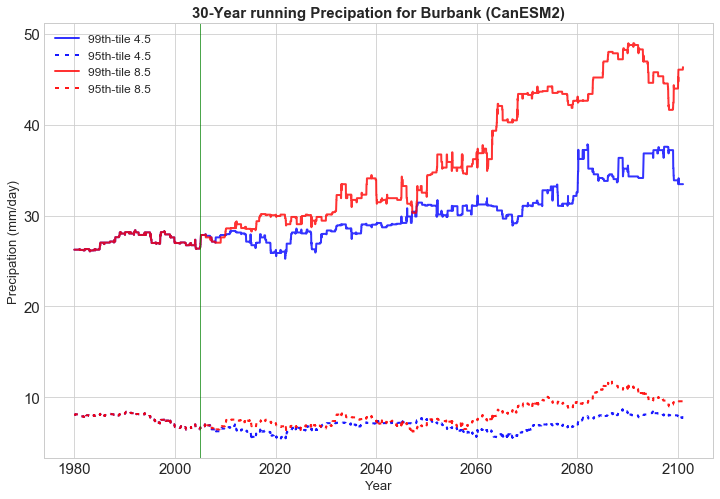

In [421]:

plt.plot(projectedDF.index, canesm45_quant99, color = 'b', ls = 'solid', alpha = 0.8, label = '99th-tile 4.5')
plt.plot(projectedDF.index, canesm45_quant95, color = 'b', ls = 'dashed', alpha = 0.9, dashes=(2, 3), label = '95th-tile 4.5')
plt.plot(projectedDF.index, canesm85_quant99, color = 'r', ls = 'solid', alpha = 0.8, label = '99th-tile 8.5')
plt.plot(projectedDF.index, canesm85_quant95, color = 'r', ls = 'dashed', alpha = 0.9, dashes=(2, 3), label = '95th-tile 8.5')
plt.xlabel('Year', fontsize = 13)
plt.ylabel('Precipation (mm/day)', fontsize = 13)
plt.title('30-Year running Precipation for Burbank (CanESM2)', weight = 'bold', fontsize = 15)
plt.legend()
plt.style.use('seaborn-whitegrid')
plt.axvline(x= '2005', alpha = 0.7, color = 'g', linewidth = 1.0)
axes = plt.gca()
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

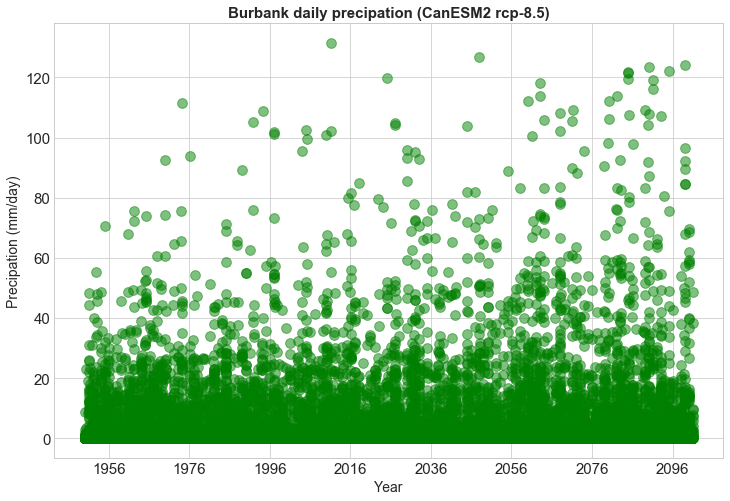

In [422]:
plt.scatter(projectedDF.index, projectedDF['CanESM2_rcp85'], s = 95, color = 'green', alpha = 0.5)
axes = plt.gca()
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Precipation (mm/day)', fontsize = 14)
plt.title('Burbank daily precipation (CanESM2 rcp-8.5)', weight = 'bold', fontsize = 15)
plt.show()

In [423]:
# set a different threshold for every year
threshold = projectedDF.groupby(projectedDF.index.year).quantile(.99, interpolation='linear')

In [424]:
threshold.tail()

test,CNRM-CM5_rcp45,CNRM-CM5_rcp85,CanESM2_rcp45,CanESM2_rcp85,HadGEM2-ES_rcp45,HadGEM2-ES_rcp85,MIROC5_rcp45,MIROC5_rcp85
Date,,,,,,,,
2096,23.782362,16.666996,18.917361,11.367107,23.884894,21.528447,47.956706,21.223822
2097,30.095873,49.447584,34.589544,9.573080,32.090479,50.021024,28.683657,30.591678
2098,49.558540,24.416143,27.787836,33.215027,21.354522,21.857977,36.011899,32.449475
2099,21.931150,22.498175,25.633808,86.395935,33.125827,47.134449,30.633016,33.741607
2100,16.963917,55.876817,28.848138,58.881699,NaN,NaN,NaN,NaN


In [425]:
col_names = list(threshold)
col_names

['CNRM-CM5_rcp45',
 'CNRM-CM5_rcp85',
 'CanESM2_rcp45',
 'CanESM2_rcp85',
 'HadGEM2-ES_rcp45',
 'HadGEM2-ES_rcp85',
 'MIROC5_rcp45',
 'MIROC5_rcp85']

In [426]:
df = projectedDF.copy()


In [427]:
for col in col_names:
    for year in threshold.index:
        projectedDF.loc[(projectedDF.index.year == year), col] = projectedDF.loc[(projectedDF.index.year == year), col].apply(lambda la: np.nan if la < threshold.loc[year, col]  else la)
        

In [428]:
#plt.rcParams['lines.linewidth'] = 2
#plt.rcParams.update({'font.size': 12})
#axisfontsize = 15;

In [429]:
#the same threshold every year
threshold2 = df.loc['1961-01-01':'1990-12-31', :].quantile(.99, interpolation='linear')

In [430]:
threshold2

test
CNRM-CM5_rcp45      28.264538
CNRM-CM5_rcp85      28.264538
CanESM2_rcp45       28.011856
CanESM2_rcp85       28.011856
HadGEM2-ES_rcp45    26.949920
HadGEM2-ES_rcp85    26.949920
MIROC5_rcp45        26.974846
MIROC5_rcp85        26.974846
Name: 0.99, dtype: float64

# df2 = months are column headers, only above 99th percentile data

In [431]:
#df2 = projectedDF.loc[:, ['CanESM2_rcp85']]
#df2 = df2.pivot_table(values = 'CanESM2_rcp85', index = df2.index.year, columns = df2.index.month)
#df2.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May',  'Sep', 'Oct', 'Nov', 'Dec']
#df2.head(20)

In [432]:
# Different threshold for different GCMs
for col in col_names:
    df.loc[:, col] = df.loc[:, col].apply(lambda la: np.nan if la < threshold2[col]  else la)

# df =  data above 99th percentile only (n/a replaced on others)

In [433]:
# df3 is slicing down the df to look at one GCM at a time
df3 = df.loc[:, ['CanESM2_rcp85']]
df3.head()

test,CanESM2_rcp85
Date,
1950-01-01,NaN
1950-01-02,NaN
1950-01-03,NaN
1950-01-04,NaN
1950-01-05,NaN


In [434]:
# df = total number of days above 99th precentile each year
df = df.groupby(df.index.year).count()
df.head(5)

test,CNRM-CM5_rcp45,CNRM-CM5_rcp85,CanESM2_rcp45,CanESM2_rcp85,HadGEM2-ES_rcp45,HadGEM2-ES_rcp85,MIROC5_rcp45,MIROC5_rcp85
Date,,,,,,,,
1950,9,9,0,0,3,3,1,1
1951,3,3,4,4,1,1,4,4
1952,1,1,3,3,7,7,11,11
1953,0,0,4,4,7,7,0,0
1954,6,6,4,4,3,3,1,1


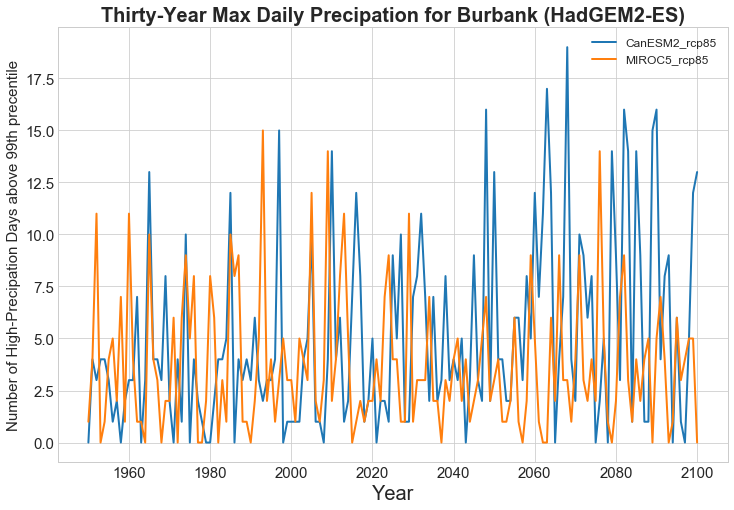

In [435]:
#plt.plot(df.index, df.loc[:, ['CanESM2_rcp85',  'MIROC5_rcp85' ]], marker = 'o', markersize = 0, linewidth = 1.5)
plt.plot(df.index, df['CanESM2_rcp85'],marker='o', markersize=0, label = 'CanESM2_rcp85' , linewidth = 2)
plt.plot(df.index, df['MIROC5_rcp85'],marker='o', markersize=0, label = 'MIROC5_rcp85', linewidth = 2)
#plt.plot(df.index, df['CNRM-CM5_rcp85'],marker='o', markersize=0, label = 'CNRM-CM5_rcp85')
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Number of High-Precipation Days above 99th precentile', fontsize = 15)
plt.title('Thirty-Year Max Daily Precipation for Burbank (HadGEM2-ES)', weight = 'bold', fontsize = 20)
plt.legend()
#plt.rcParams['figure.figsize'] = [25, 15]
plt.show()

In [436]:
df3['month'] = projectedDF.index.month 
df3['day'] = projectedDF.index.day
df3['period']=df3.apply(lambda x:'%d_%d' % (x['month'],x['day']),axis=1)

df3.head()


test,CanESM2_rcp85,month,day,period
Date,,,,
1950-01-01,NaN,1,1,1_1
1950-01-02,NaN,1,2,1_2
1950-01-03,NaN,1,3,1_3
1950-01-04,NaN,1,4,1_4
1950-01-05,NaN,1,5,1_5


In [437]:
#keeping the rows with data only (dropping all Nan rows based upon canesm)
df3 = df3[np.isfinite(df3['CanESM2_rcp85'])]
oii = df3.groupby(df3.period).count().sort_values(by = max, ascending = False)
df3.head(10)

test,CanESM2_rcp85,month,day,period
Date,,,,
1951-02-04,30.991448,2,4,2_4
1951-02-05,48.180683,2,5,2_5
1951-02-14,44.317930,2,14,2_14
1951-10-25,31.223133,10,25,10_25
1952-03-30,40.165921,3,30,3_30
1952-11-23,55.226959,11,23,11_23
1952-11-29,33.566967,11,29,11_29
1953-01-10,47.945596,1,10,1_10
1953-01-11,34.384236,1,11,1_11


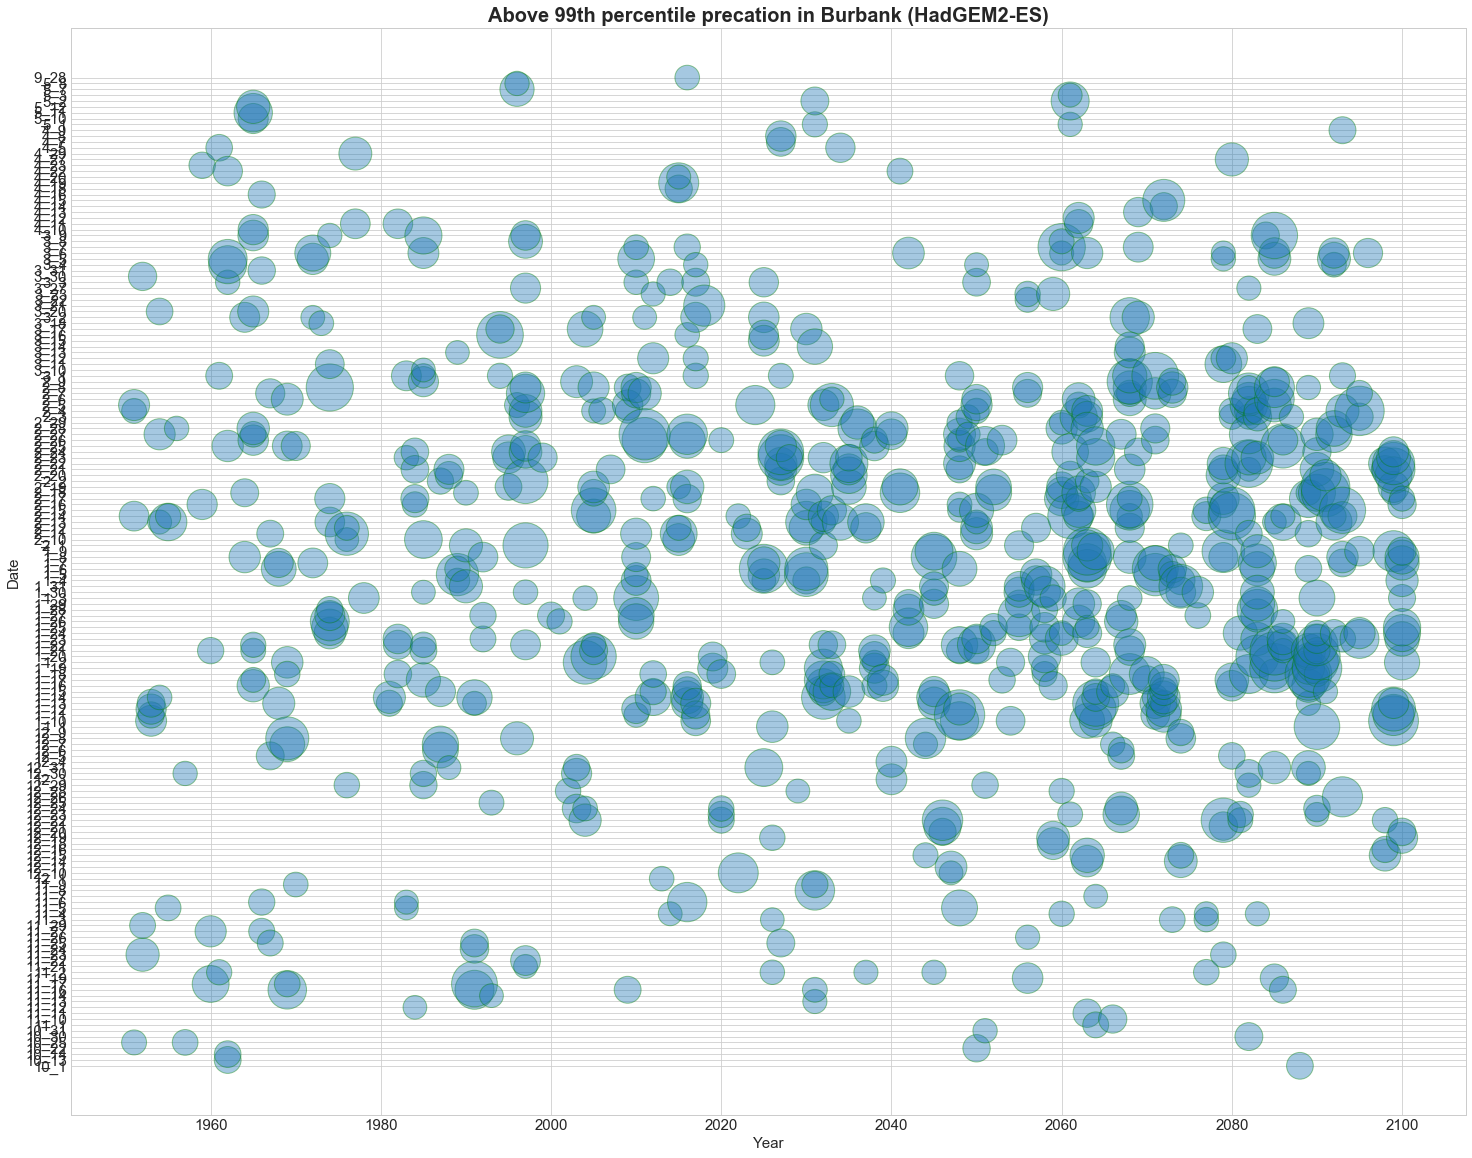

In [444]:
import calendar

plt.scatter(x = df3.index.year, y = df3['period'], s = df3.CanESM2_rcp85 * 20, alpha = 0.4, edgecolors='green')
#plt.yticks(np.arange(3_15, 11_21, 2_4 ))
#my_yticks = ['1_1', '2_1', '3_1', '4_1', '5_1', '9_1' , '10_1' , '11_1',  '12_1']
#plt.yticks(df3['month'], my_yticks)
plt.rcParams['figure.figsize'] = [25, 20]
plt.xlabel('Year', fontsize = 15)
#plt.yticks(np.arange(12), calendar.month_name[1:13], rotation=45)
plt.ylabel('Date', fontsize = 15)
plt.title('Above 99th percentile precation in Burbank (HadGEM2-ES)', weight = 'bold', fontsize = 20)
plt.show()

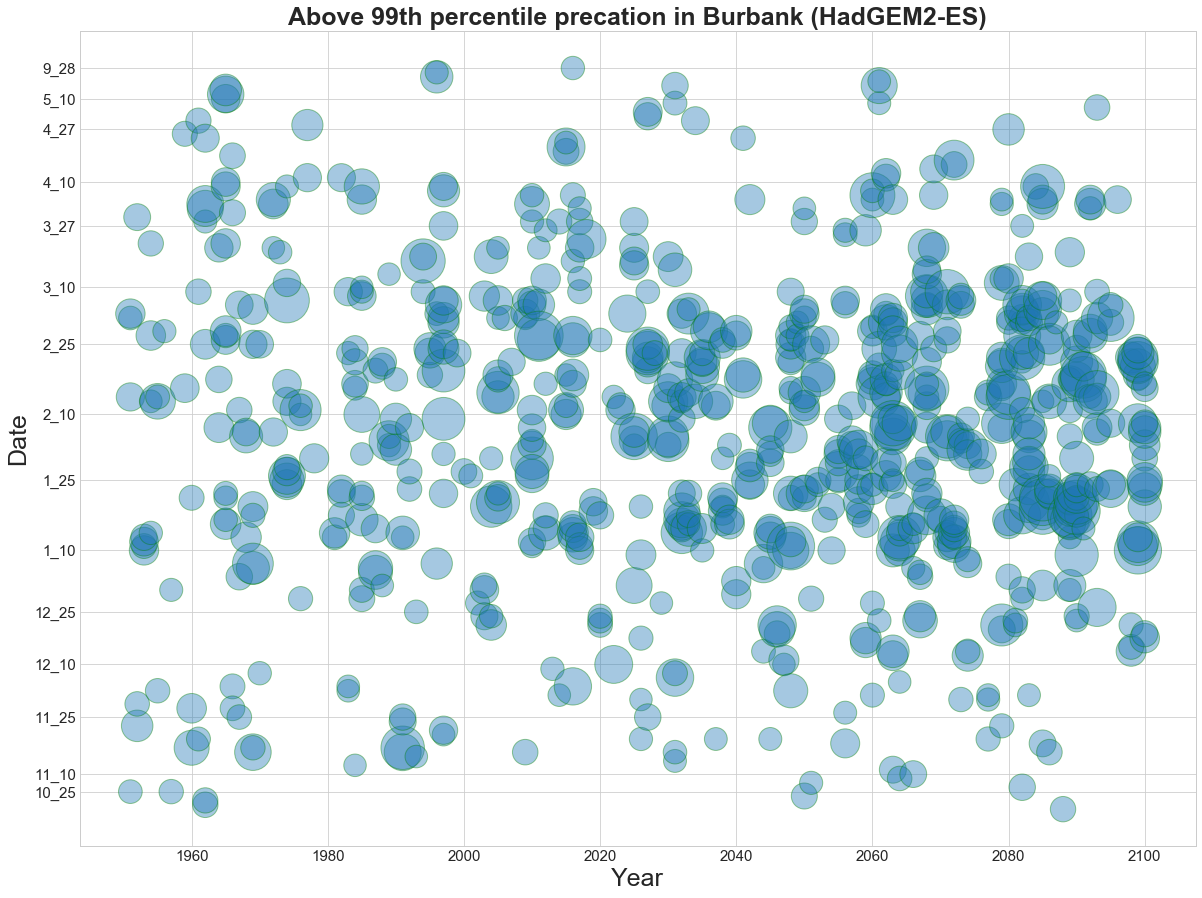

In [458]:
plt.scatter(x = df3.index.year, y = df3['period'], s = df3.CanESM2_rcp85 * 18, alpha = 0.4, edgecolors='green')
fuckyou = [ 'harami' ]
my_yticks = ['1_25', '2_10', '2_25','3_10', '3_27', '4_10', '4_27', '5_10', '9_28' , '10_25' , '11_10', '11_25', '12_10', '12_25', '1_10']
plt.yticks(df3['month'], my_yticks)
plt.yticks(my_yticks)
plt.rcParams['figure.figsize'] = [20, 15]
plt.xlabel('Year', fontsize = 25)
plt.ylabel('Date', fontsize = 25)
plt.title('Above 99th percentile precation in Burbank (HadGEM2-ES)', weight = 'bold', fontsize = 25)
plt.show()

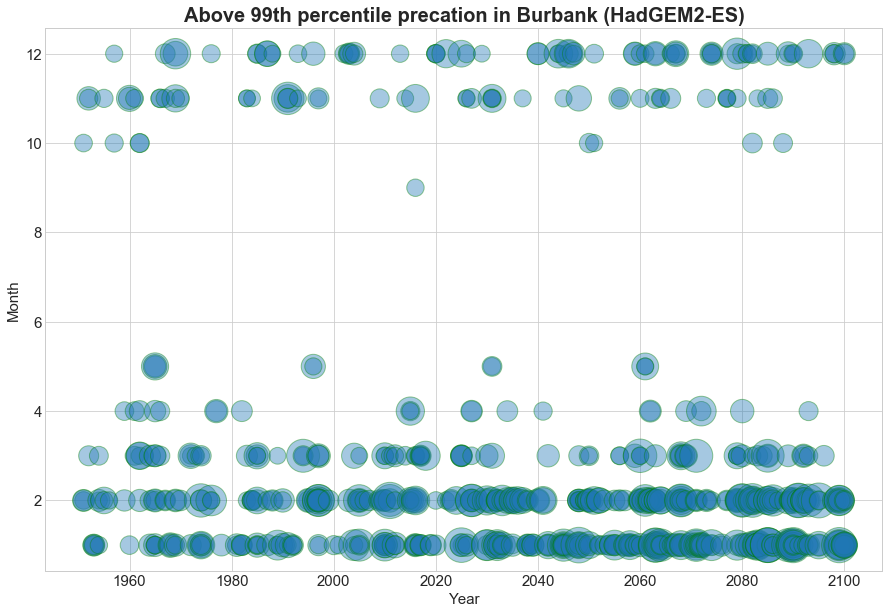

In [446]:
plt.scatter(x = df3.index.year, y = df3['month'], s = df3.CanESM2_rcp85 * 10, alpha = 0.4, edgecolors='green')
plt.rcParams['figure.figsize'] = [15, 10]
#labels = ['Jan',  'Mar',  'May', 'Sep', 'Oct', 'Nov']
#plt.yticks(df3.index.month, labels, rotation='horizontal')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Month', fontsize = 15)
plt.title('Above 99th percentile precation in Burbank (HadGEM2-ES)', weight = 'bold', fontsize = 20)
plt.show()
plt.gcf().clear()

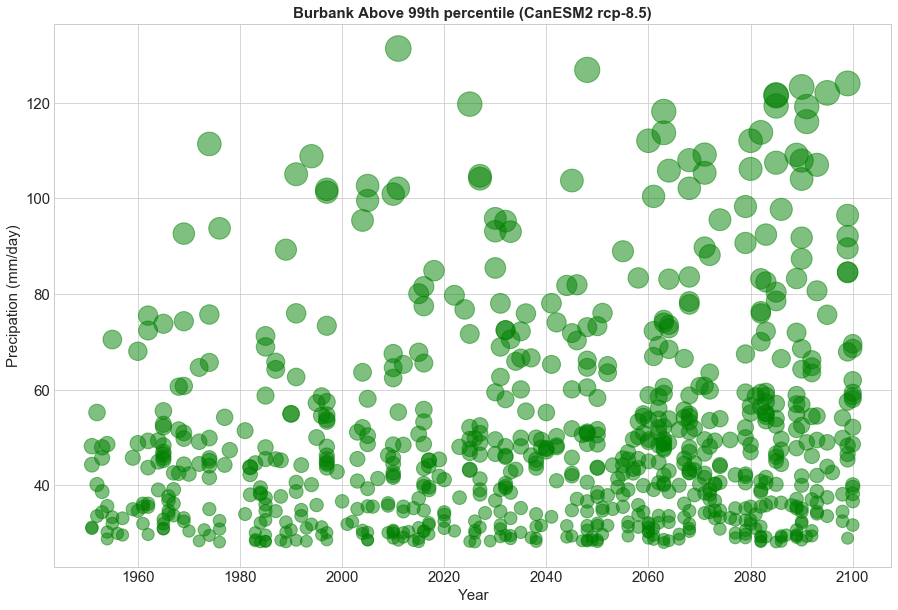

In [441]:
plt.scatter(x = df3.index.year, y = df3.CanESM2_rcp85, s = df3.CanESM2_rcp85 * 5, alpha = 0.5, color='green')
#plt.scatter(projectedDF.index, projectedDF['CanESM2_rcp85'], s = 95, color = 'green', alpha = 0.5)
axes = plt.gca()
plt.rcParams['figure.figsize'] = [25, 15]
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Precipation (mm/day)', fontsize = 15)
plt.title('Burbank Above 99th percentile (CanESM2 rcp-8.5)', weight = 'bold', fontsize = 15)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()


### HadGEM2

In [442]:
plt.plot(threshold.index, hadgem45_quant99, color = 'b', ls = 'solid', alpha = 0.8,label = '99th-tile 4.5')
plt.plot(projectedDF.index, hadgem85_quant99, color = 'r', ls = 'solid', alpha = 0.8, label = '99th-tile 8.5')
plt.axvline(x= '2005', alpha = 0.7, color = 'g', linewidth = 1.0)
plt.xlabel('Year')
plt.ylabel('Percentiles maximum Daily Temperature ( $^{\circ}$ C)')
plt.title('Thirty-Year Max Daily Precipation for Burbank (HadGEM2-ES)', weight = 'bold')
plt.legend()
sns.set_style("whitegrid")
axes = plt.gca()

plt.show()

NameError: name 'hadgem45_quant99' is not defined

### MIROC5

In [ ]:
miroc45_quant90 = projectedDF['MIROC5_rcp45'].rolling(10957).quantile(.90, interpolation='lower')
miroc45_quant95 = projectedDF['MIROC5_rcp45'].rolling(10957).quantile(.95, interpolation='lower')
miroc85_quant90 = projectedDF['MIROC5_rcp85'].rolling(10957).quantile(.90, interpolation='lower')
miroc85_quant95 = projectedDF['MIROC5_rcp85'].rolling(10957).quantile(.95, interpolation='lower')

In [ ]:
plt.plot(projectedDF.index, miroc45_quant90, color = 'b', ls = 'dashed', alpha = 0.8, dashes=(2, 2), label = '90th-tile 4.5')
plt.plot(projectedDF.index, miroc45_quant95, color = 'b', ls = 'solid', alpha = 0.8, label = '95th-tile 4.5')
plt.plot(projectedDF.index, miroc85_quant90, color = 'r', ls = 'dashed', alpha = 0.8, dashes=(2, 2), label = '90th-tile 8.5')
plt.plot(projectedDF.index, miroc85_quant95, color = 'r', ls = 'solid', alpha = 0.8, label = '95th-tile 8.5')
plt.xlabel('Year')
plt.ylabel('Percentiles maximum Daily Temperature ( $^{\circ}$ C)')
plt.title('Thirty-Year Max Daily Temp for Burbank (MIROC5)', weight = 'bold')
#plt.text(723999, 30.3, 'Historical Simulations', fontsize = 13)
#plt.text(739999, 30.3, 'Projections', fontsize = 13)
plt.axvline(x= '2005', alpha = 0.7, color = 'g', linewidth = 1.0)
plt.legend()
sns.set_style("whitegrid")
axes = plt.gca()
axes.set_ylim([30,38])
#plt.savefig('test4.pdf', bbox_inches='tight')
plt.show()

In [ ]:
on['a'].head()

In [ ]:
from numpy import random
on = pd.DataFrame(np.random.randn(1000, 2), columns=['a', 'b'])
on['b'] = on['b'] + np.arange(1000)
on.plot(kind='hexbin', x='a', y='b', gridsize=25)